In [1]:
import fire as fire
import torch
from torch.utils.data import DataLoader
from nbs.dl2.exp.nb_02 import getMnistData
from nbs.dl2.exp.nb_03 import createDataLoaders
from nbs.dl2.exp.nb_05 import cosineScheduler
from nbs.dl2.exp.nb_06 import normalizeVectors, exportNotebook
import torch.nn.functional as Functional
%matplotlib inline

In [2]:
#export
from exp.nb_06 import *
from torch import nn, optim

In [3]:
# xTraining, yTraining, xValidation, yValidation = list(map(lambda x: x.cuda(),getMnistData()))
xTraining, yTraining, xValidation, yValidation = list(map(lambda x: x,getMnistData()))
xTrainingNormalized, xValidationNormalized = normalizeVectors(xTraining, xValidation)
(xTrainingNormalized.mean(), xTrainingNormalized.std, xValidationNormalized.mean(), xValidationNormalized.std())

(tensor(-3.0466e-06),
 <function Tensor.std>,
 tensor(-3.7518e-07),
 tensor(1.0000))

In [4]:
numberOfClasses = 10
hiddenLayerOutput = 50
batchSize = 64
lossFuction = Functional.cross_entropy

In [5]:
trainingDataSet, validationDataSet = Dataset(xTrainingNormalized, yTraining), Dataset(xValidationNormalized, yValidation)

In [6]:
trainingDataLoader, validationDataLoader = createDataLoaders(trainingDataSet, validationDataSet, batchSize)

In [7]:
imageDataBunch = DataBunch(trainingDataLoader, validationDataLoader, numberOfClasses)

In [18]:
layerSizes = [8, 16, 32, 64, 64]

In [19]:
phases = [0.3, 0.7]
weightsScheduler = aggregateSchedulers(phases, createCosineSchedulers(0.3, 0.6, 0.2)) 
biasScheduler = aggregateSchedulers(phases, createCosineSchedulers(0.9, 1.8, 0.6))

In [20]:
#export
class Subscriber:
    def __init__(self):
        self._totalEpochs = 0
        self._currentEpoch = 0

    def postEpoch(self, epochNumber):
        pass

    def postBatchEvaluation(self, predictions, validationData):
        pass

    def preBatchEvaluation(self):
        pass

    def preEpoch(self, epoch, dataLoader):
        self._currentEpoch = epoch
        pass

    def preModelTeach(self, model, epochs):
        self._totalEpochs = epochs
        pass

    def postModelTeach(self):
        pass


In [21]:
#export
class StatisticsSubscriber(Subscriber):

    def __init__(self,
                 accuracyFunction=accuracy,
                 name="Steve"):
        super().__init__()
        self._epochAccuracy = 0.
        self._epochLoss = 0.
        self._numberOfBatches = 0
        self._batchSize = 1.
        self._totalBatchesPerEpoch = 1.
        self._currentBatch = 1.
        self._totalTrainingBatches = -1
    
        self._accuracyFunction = accuracyFunction
        self._name = name
    def preModelTeach(self, model, epochs):
        super().preModelTeach(model, epochs)
        self._totalTrainingBatches = -1

    def preEpoch(self, epoch, dataLoader: DataLoader):
        super().preEpoch(epoch, dataLoader)
        self._numberOfBatches = len(dataLoader)
        self._epochAccuracy, self._epochLoss, self._currentBatch = 0., 0., 0.
        self._batchSize = dataLoader.batch_size
        self._totalBatchesPerEpoch = self._numberOfBatches
        if self._totalTrainingBatches < 1:
            self._totalTrainingBatches = self._totalEpochs * self._totalBatchesPerEpoch 
            
    def calculateCurrentProgress(self):
        return ((self._currentBatch + self._totalBatchesPerEpoch * self._currentEpoch) /
                self._totalTrainingBatches) - 1e-6

    def postBatchEvaluation(self, predictions, validationData):
        super().postBatchEvaluation(predictions, validationData)
        self._currentBatch += 1
        self._epochAccuracy += self._accuracyFunction(predictions, validationData)

    def postBatchLossConsumption(self, loss):
        self._epochLoss += loss

    def postEpoch(self, epochNumber):
        super().postEpoch(epochNumber)
        print("Epoch #{} {}: Loss {} Accuracy {}".format(epochNumber,
                                                         self._name,
                                                         self._epochLoss / self._numberOfBatches,
                                                         self._epochAccuracy / self._numberOfBatches))


In [22]:
#export
class ValidationSubscriber(StatisticsSubscriber):

    def __init__(self):
        super().__init__(name="Validation")


In [23]:
#export
class ModelLayerHook:
    def __init__(self, model, callback=lambda *args: None) -> None:
        super().__init__()
        self._registeredHook = model.register_forward_hook(callback)

    def remove(self): self._registeredHook.remove()

    def __del__(self): self.remove()


In [24]:
#export
class StatsHook:
    def __init__(self, model) -> None:
        super().__init__()
        self._initializeStorage()
        self._modelLayerHook = ModelLayerHook(model, self._appendStats)

    def remove(self): self._modelLayerHook.remove()

    def __del__(self): self.remove()

    def _initializeStorage(self):
        self.aggregatedStandardDeviations = []
        self.aggregatedMeans = []

    def _appendStats(self, module, input, output):
        self.aggregatedMeans.append(output.data.mean())
        self.aggregatedStandardDeviations.append(output.data.std())


In [25]:
#export
class HookedSubscriber(Subscriber):
    def __init__(self):
        super().__init__()
        self._statsHooks = []

    def preModelTeach(self, model, epochs):
        super().preModelTeach(model, epochs)
        self._statsHooks = [StatsHook(layer) for layer in model]


    def postModelTeach(self):
        super().postModelTeach()

    def plotMeansAndStandardDeviations(self):
        fig, (ax0, ax1) = plotter.subplots(1, 2, figsize=(10, 4))
        for statsHook in self._statsHooks:
            layerMeans, layerStandarDeviations = statsHook.aggregatedMeans, statsHook.aggregatedStandardDeviations
            ax0.plot(layerMeans)
            ax1.plot(layerStandarDeviations)
        plotter.legend(range(len(self._statsHooks)))


In [26]:
#export
class TrainingSubscriber(StatisticsSubscriber, HookedSubscriber):

    def __init__(self,
                 lossFunction=Functional.cross_entropy,
                 schedulingFunctions=[cosineScheduler(1e-1, 1e-6), cosineScheduler(1e-1, 1e-6)], ):
        super().__init__(name="Training")
        self._optimizer = None
        self._schedulingFunctions = schedulingFunctions
        self._lossFunction = lossFunction

    def preModelTeach(self, model, epochs):
        super().preModelTeach(model, epochs)
        self._optimizer = optim.SGD(model.parameters(), self._schedulingFunctions[0](0))
        self._totalEpochs = epochs

    def postBatchEvaluation(self, predictions, valdationData):
        super().postBatchEvaluation(predictions, valdationData)
        calculatedLoss = self._lossFunction(predictions, valdationData)
        self._teachModel(calculatedLoss)
        self.postBatchLossConsumption(calculatedLoss)

    def _teachModel(self, loss):
        loss.backward()
        self._optimizer.step()
        self._optimizer.zero_grad()

    def preBatchEvaluation(self):
        super().preBatchEvaluation()
        self._annealLearningRate()

    def _annealLearningRate(self):
        for parameterGroup, schedulingFunction in zip(self._optimizer.param_groups, self._schedulingFunctions):
            parameterGroup['lr'] = schedulingFunction(self._currentEpoch / self._totalEpochs)


In [27]:
#export
class TeacherEnhanced:
    def __init__(self,
                 dataBunch,
                 trainingSubscriber: TrainingSubscriber,
                 validationSubscriber: ValidationSubscriber):
        self._dataBunch = dataBunch
        self._trainingSubscriber = trainingSubscriber
        self._validationSubscriber = validationSubscriber

    def teachModel(self, model, numberOfEpochs):
        self._notifiyPreTeach(model, numberOfEpochs)
        for epoch in range(numberOfEpochs):
            self._trainModel(model,
                             epoch)
            self._validateModel(model,
                                epoch)
        self._notifiyPostTaught()

    def _notifiyPreTeach(self, model, epochs):
        self._trainingSubscriber.preModelTeach(model, epochs)
        self._validationSubscriber.preModelTeach(model, epochs)

    def _notifiyPostTaught(self):
        self._trainingSubscriber.postModelTeach()
        self._validationSubscriber.postModelTeach()

    def _trainModel(self, model, epoch):
        self._processData(model,
                          self._dataBunch.trainingDataSet,
                          epoch,
                          self._trainingSubscriber)

    def _validateModel(self, model, epoch):
        with torch.no_grad():
            self._processData(model,
                              self._dataBunch.validationDataSet,
                              epoch,
                              self._validationSubscriber)

    def _processData(self,
                     model,
                     dataLoader,
                     epoch,
                     processingSubscriber: Subscriber):
        processingSubscriber.preEpoch(epoch, dataLoader)
        for _xDataBatch, _yDataBatch in dataLoader:
            processingSubscriber.preBatchEvaluation()
            _predictions = model(_xDataBatch)
            processingSubscriber.postBatchEvaluation(_predictions, _yDataBatch)
        processingSubscriber.postEpoch(epoch)


In [28]:
validationSubscriber = ValidationSubscriber()

In [29]:
trainingSubscriber = TrainingSubscriber()

In [46]:
trainingSubscriber._optimizer.param_groups
# for param in trainingSubscriber._optimizer.param_groups:
#     print(param['lr'])

[{'params': [Parameter containing:
   tensor([[[[-0.0249,  0.2594,  0.1165,  0.0363, -0.0946],
             [ 0.2621,  0.3368,  0.4209,  0.1524,  0.1522],
             [ 0.0491,  0.1944,  0.2550,  0.2111,  0.2131],
             [-0.0022,  0.1181,  0.0743, -0.1376, -0.1042],
             [-0.0031, -0.1319, -0.2700, -0.2550,  0.0452]]],
   
   
           [[[ 0.0448,  0.0561,  0.2916,  0.3965,  0.3204],
             [ 0.1201,  0.2537,  0.3840,  0.4766,  0.4207],
             [ 0.3045,  0.1513,  0.2450,  0.3550,  0.2940],
             [ 0.0713,  0.4140,  0.2775,  0.3394,  0.0490],
             [ 0.1815,  0.0195, -0.0351, -0.0171, -0.0773]]],
   
   
           [[[ 0.0427, -0.1221, -0.1070,  0.1450,  0.0961],
             [ 0.0199,  0.1397, -0.0697,  0.0218, -0.1152],
             [ 0.0271, -0.1818, -0.1323, -0.0345,  0.0978],
             [-0.0108,  0.0058, -0.1303,  0.0429, -0.1875],
             [-0.0405,  0.1485, -0.0640,  0.0151,  0.0202]]],
   
   
           [[[ 0.0084,  0.1058, -0.

In [31]:
teacher = TeacherEnhanced(imageDataBunch, 
                          trainingSubscriber,
                          validationSubscriber
                         )

In [36]:
# convolutionalModelSR1 = createBetterConvolutionModel(numberOfClasses, layerSizes).cuda()
convolutionalModelSR1 = createBetterConvolutionModel(numberOfClasses, layerSizes)

In [37]:
accuracy(convolutionalModelSR1(xValidationNormalized), yValidation)

tensor(0.0967)

In [38]:
teacher.teachModel(convolutionalModelSR1, 2)

Epoch #0 Training: Loss 0.9823625683784485 Accuracy 0.6515744924545288
Epoch #0 Validation: Loss 0.0 Accuracy 0.9509493708610535
Epoch #1 Training: Loss 0.1214572861790657 Accuracy 0.9618765711784363
Epoch #1 Validation: Loss 0.0 Accuracy 0.9720134735107422


In [39]:
accuracy(convolutionalModelSR1(xValidationNormalized), yValidation)

tensor(0.9717)

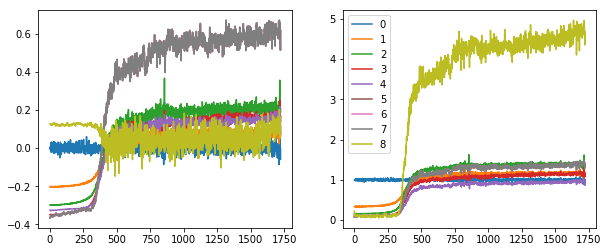

In [204]:
trainingSubscriber.plotMeansAndStandardDeviations()

In [205]:
teacher.teachModel(convolutionalModelSR1, 2)

Epoch #0 Training: Loss 0.08558310568332672 Accuracy 0.9729459881782532
Epoch #0 Validation: Loss 0.0 Accuracy 0.978935956954956
Epoch #1 Training: Loss 0.05180056765675545 Accuracy 0.9840153455734253
Epoch #1 Validation: Loss 0.0 Accuracy 0.9827927350997925


In [206]:
accuracy(convolutionalModelSR1(xValidationNormalized), yValidation)

tensor(0.9826, device='cuda:0')

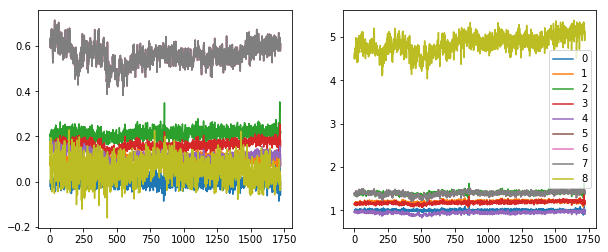

In [207]:
trainingSubscriber.plotMeansAndStandardDeviations()

In [10]:
exportNotebook()

<IPython.core.display.Javascript object>